# BSUD Project 2

# 1.Import Labraries: 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from textblob import TextBlob
import os
import nltk


# 2.Set Up Paths

In [41]:

data_folder = "../data"
reviews_path = os.path.join(data_folder, "tripadvisor_hotel_reviews.csv")
sentiment_path = os.path.join(data_folder, "tripadvisor_hotel_reviews_sentiment.csv")
target_sentiment_path = os.path.join(data_folder, "tripadvisor_hotel_reviews_target_sentiment.csv")
stopwords_path = os.path.join(data_folder, "Additional_Stopwords.txt")

import os

# Print each file path and check existence
print("Reviews path exists:", os.path.exists(reviews_path))
print("Sentiment path exists:", os.path.exists(sentiment_path))
print("Target sentiment path exists:", os.path.exists(target_sentiment_path))
print("Stopwords path exists:", os.path.exists(stopwords_path))



Reviews path exists: True
Sentiment path exists: True
Target sentiment path exists: True
Stopwords path exists: True


# 3.Load Data

In [36]:
# Load datasets
print(os.path.exists(stopwords_path))  # Should return True if the file exists

import os

# Check current working directory
print(os.getcwd())

# Replace 'absolute_path_to_data_folder' with the full path to your data folder
stopwords_path =os.path.join(data_folder, "Additional_Stopwords.txt")

# Load stopwords
try:
    with open(stopwords_path, "r") as file:
        additional_stopwords = file.read().splitlines()
    print("Stopwords loaded successfully!")
except Exception as e:
    print(f"Error loading stopwords: {e}")



True
/Users/muhi/PycharmProjects/scientificProject/models
Stopwords loaded successfully!


# 4.Preprocessing

In [42]:
import os
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Paths to data files
data_folder = "../data"
reviews_path = os.path.join(data_folder, "tripadvisor_hotel_reviews.csv")
stopwords_path = os.path.join(data_folder, "Additional_Stopwords.txt")

# Confirm paths are valid
print("Reviews path exists:", os.path.exists(reviews_path))
print("Stopwords path exists:", os.path.exists(stopwords_path))

# Load the dataset
reviews = pd.read_csv(reviews_path)

# Load additional stopwords
with open(stopwords_path, "r") as file:
    additional_stopwords = file.read().splitlines()

# NLTK setup
nltk.download('stopwords')
nltk.download('punkt')

# Combine NLTK stopwords and additional stopwords
nltk_stopwords = set(stopwords.words("english"))
combined_stopwords = nltk_stopwords.union(set(additional_stopwords))

# Define preprocessing function
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in combined_stopwords]
    return " ".join(tokens)

# Apply preprocessing to the 'Review' column
reviews["processed_text"] = reviews["Review"].apply(preprocess)

# Display processed text
print(reviews[["Review", "processed_text"]].head())


Reviews path exists: True
Stopwords path exists: True


[nltk_data] Downloading package stopwords to /Users/muhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/muhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                              Review  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                      processed_text  
0  expensive parking deal anniversary arrived lat...  
1  ok nothing special charge diamond member hilto...  
2  room 4 4 large mediterranean suite comfortable...  
3  unique wonderful excellent short stroll main d...  
4  seahawk game awesome downfall view building co...  


# 5.Sentiment Analysis

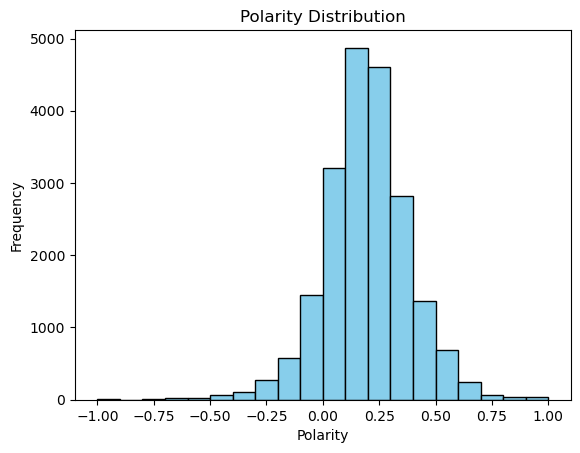

Highly Positive Reviews:
                                                  Review  polarity
68    pay location location perfect walking distance...   1.00000
581   stay, just returned mandira took mum 75 years ...   0.77500
763   best marriotts stayed, check checkout staff wo...   0.77500
1145  absolutely wonderful wonderful serene oasis ci...   1.00000
1197  casablanca perfect, just returned 6 nights won...   0.84375
Highly Negative Reviews:
                                                 Review  polarity
42   warwick bad good reviews warwick shocks staff ... -0.275000
65   hated inn terrible, room-service horrible staf... -0.633333
141  terrible experience awful night stay, planned ... -0.450000
174  upgrade outdated arrived given junior suite ma... -0.292593
200  stay plenty nice hotels seattle, not, terrible... -0.366667


In [15]:
# Sentiment analysis with TextBlob
reviews["polarity"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews["subjectivity"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Visualize sentiment polarity distribution
plt.hist(reviews["polarity"], bins=20, color="skyblue", edgecolor="black")
plt.title("Polarity Distribution")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()
# Recreate the polarity column
reviews["polarity"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Aspect-Based Sentiment Analysis
reviews["aspect_sentiment"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

print("Highly Positive Reviews:\n", reviews[reviews["polarity"] > 0.75][["Review", "polarity"]].head())
print("Highly Negative Reviews:\n", reviews[reviews["polarity"] < -0.25][["Review", "polarity"]].head())

#most reviews lean towards a neutral-to-positive sentiment. --> 0 to 0.5


# 6.Sentiment Analysis by Aspect

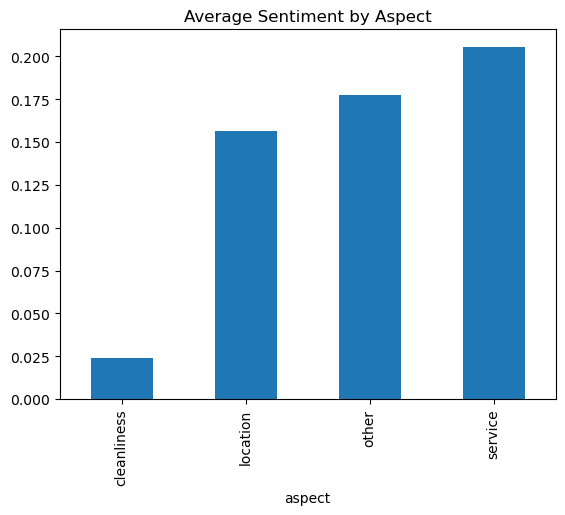

In [62]:
aspects = {
    "service": ["service", "staff", "helpful"],
    "location": ["location", "area", "nearby"],
    "cleanliness": ["clean", "dirty", "tidy"]
}

def extract_aspects(text):
    for aspect, keywords in aspects.items():
        if any(keyword in text for keyword in keywords):
            return aspect
    return "other"

reviews["aspect"] = reviews["processed_text"].apply(extract_aspects)
reviews["aspect_sentiment"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

aspect_summary = reviews.groupby("aspect")["aspect_sentiment"].mean()
aspect_summary.plot(kind="bar", title="Average Sentiment by Aspect")
plt.show()

#All aspects (e.g., cleanliness, location, service) show positive average sentiment as the bars are above zero. This indicates that, on average, customers have a favorable opinion across all analyzed aspects.

#Service and Location have the highest average sentiment scores, suggesting customers were most satisfied with the quality of servic and the convenience or attractiveness of the location.



# 7.Topic Modelling

Loaded 20491 reviews.
Text preprocessing complete.
TF-IDF matrix shape: (20491, 1000)
LDA model fitted.
Topic 1:
small, bed, night, good, location, stay, nice, great, hotel, room
Topic 2:
staff, manager, day, night, stay, desk, service, told, room, hotel
Topic 3:
room, people, good, day, great, time, pool, food, beach, resort
Topic 4:
service, good, excellent, stayed, staff, stay, location, great, room, hotel
Topic 5:
station, staff, clean, walk, breakfast, good, location, great, room, hotel


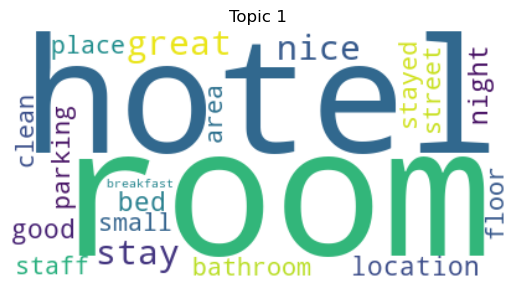

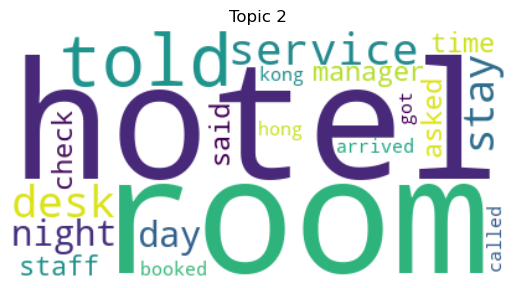

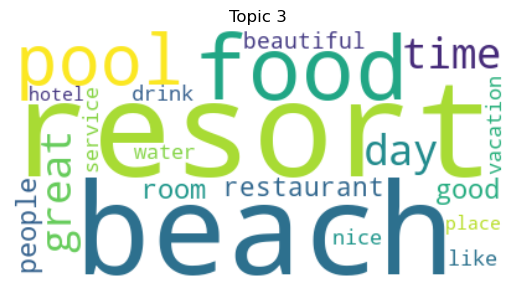

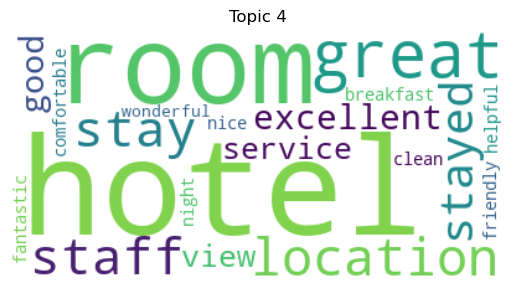

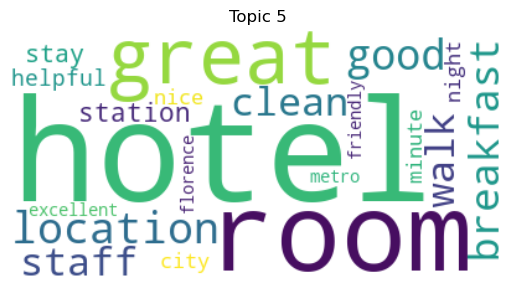

Topic 1 Reviews:
                                              Review  \
0  nice hotel expensive parking got good deal sta...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
6  cozy stay rainy city, husband spent 7 nights m...   
8  hotel stayed hotel monaco cruise, rooms genero...   

                                      processed_text  
0  nice hotel expensive parking got good deal sta...  
2  nice room 4 experience hotel monaco seattle go...  
3  unique great stay wonderful time hotel monaco ...  
6  cozy stay rainy city husband spent 7 night mon...  
8  hotel stayed hotel monaco cruise room generous...  
Topic 2 Reviews:
                                               Review  \
1   ok nothing special charge diamond member hilto...   
4   great stay great stay, went seahawk game aweso...   
13  nice hotel not nice staff hotel lovely staff q...   
15  horrible customer service hotel stay february ...   
16  disappoint

In [20]:

data_folder = "../data"
reviews_path = f"{data_folder}/tripadvisor_hotel_reviews.csv"

reviews = pd.read_csv(reviews_path)

# Ensure there is a 'Review' column in your dataset
if 'Review' not in reviews.columns:
    raise ValueError("Dataset must contain a 'Review' column.")

print(f"Loaded {len(reviews)} reviews.")
# Define preprocessing function
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    if pd.isnull(text):
        return ""
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing to reviews
reviews["processed_text"] = reviews["Review"].apply(preprocess)
print("Text preprocessing complete.")
# Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(reviews["processed_text"])

print(f"TF-IDF matrix shape: {X.shape}")
# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Set 5 topics
lda.fit(X)

print("LDA model fitted.")
# Display topics and their top words
num_words = 10  # Number of words to display per topic

for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print(", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-num_words:]]))
# Generate and display word clouds for topics
for idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(
        {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[-20:]}
    )
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {idx + 1}")
    plt.show()

# Assign each review to its dominant topic
doc_topics = lda.transform(X)
reviews["dominant_topic"] = doc_topics.argmax(axis=1)

# View reviews grouped by topic
for topic in range(lda.n_components):
    print(f"Topic {topic + 1} Reviews:")
    print(reviews[reviews["dominant_topic"] == topic][["Review", "processed_text"]].head())


# 8.Interactive Topic Modelling

In [73]:
import pandas as pd
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import os
import warnings
import multiprocessing

# Disable Hugging Face tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress deprecation warnings (optional)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Use the safer spawn method for multiprocessing
multiprocessing.set_start_method("spawn", force=True)

# Step 1: Create TF-IDF Matrix
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(reviews["processed_text"])  # Ensure "processed_text" exists

# Step 2: Train LDA Model
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Specify the number of topics
lda.fit(X)

# Step 3: Prepare Inputs for pyLDAvis
# Normalize topic-term distributions
topic_term_dists = lda.components_ / lda.components_.sum(axis=1)[:, None]

# Get document-topic distributions
doc_topic_dists = lda.transform(X)

# Calculate document lengths
doc_lengths = [len(doc.split()) for doc in reviews["processed_text"]]

# Extract vocabulary and term frequencies
vocab = vectorizer.get_feature_names_out()
term_frequency = X.sum(axis=0).A1

# Step 4: Visualize with pyLDAvis
# Enable notebook visualization
pyLDAvis.enable_notebook()

# Prepare the visualization
panel = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency,
    sort_topics=False
)

# Display the visualization
pyLDAvis.display(panel)
display(panel)
pyLDAvis.save_html(panel, 'lda_visualization.html')
print("Visualization saved to lda_visualization.html. Open this file in your browser to view the results.")


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.110035 -0.024238       1        1  35.353304
1     -0.062119 -0.061830       2        1   8.267101
2     -0.014126 -0.008990       3        1   9.211847
3     -0.048687  0.042728       4        1  21.254529
4      0.014897  0.052330       5        1  25.913219, topic_info=          Term          Freq         Total Category  logprob  loglift
711     resort  10507.000000  10507.000000  Default  30.0000  30.0000
90       beach  10597.000000  10597.000000  Default  29.0000  29.0000
825      staff  12075.000000  12075.000000  Default  28.0000  28.0000
983  wonderful   5492.000000   5492.000000  Default  27.0000  27.0000
944       view   6253.000000   6253.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
874      thing   1515.178721   5072.560172   Topic5  -5.6601   0.1421
944       view   1579.052143   6253.350570   Topic5  -5.6188  -0.0259
100     better   1438.011126   4853.037294   Topic5  -5.7124   0.1341
829       star   1407.812425   4048.087625   Topic5  -5.7336   0.2942
105        bit   1410.267037   4542.941983   Topic5  -5.7318   0.1806

[329 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
21        1  0.875833  activity
21        2  0.011107  activity
21        3  0.039137  activity
21        4  0.033849  activity
21        5  0.040195  activity
...     ...       ...       ...
998       1  0.065487      york
998       2  0.246095      york
998       3  0.447383      york
998       4  0.095129      york
998       5  0.146830      york

[1225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

Visualization saved to lda_visualization.html. Open this file in your browser to view the results.


# 9.Clustering   

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  "KMeans is known to have a memory leak on Windows "


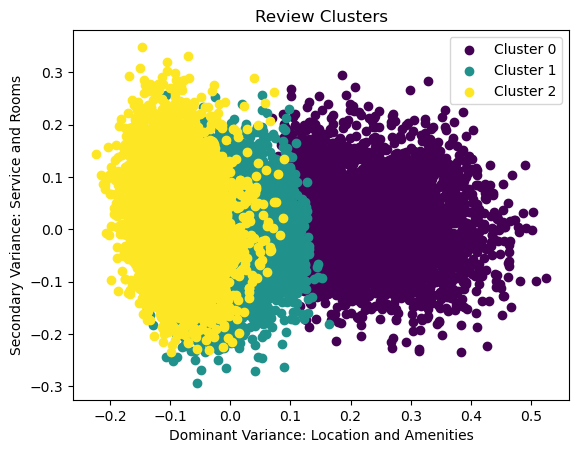

Top words in each cluster:
Top words in Cluster 0: [('beach', 8640), ('resort', 8562), ('food', 5874), ('day', 5842), ('pool', 5441), ('restaurant', 4274), ('staff', 3852), ('service', 3554), ('bar', 2962), ('place', 2895)]
Top words in Cluster 1: [('staff', 6670), ('room', 5830), ('service', 5386), ('stayed', 5276), ('day', 4590), ('place', 4385), ('bed', 4236), ('breakfast', 3820), ('view', 3510), ('floor', 3110)]
Top words in Cluster 2: [('staff', 5738), ('breakfast', 4575), ('room', 3564), ('stayed', 3337), ('walk', 3312), ('excellent', 3088), ('helpful', 3033), ('friendly', 2972), ('restaurant', 2703), ('city', 2335)]
Average Sentiment Polarity by Cluster:
cluster
0    0.166589
1    0.159500
2    0.261623
Name: polarity, dtype: float64


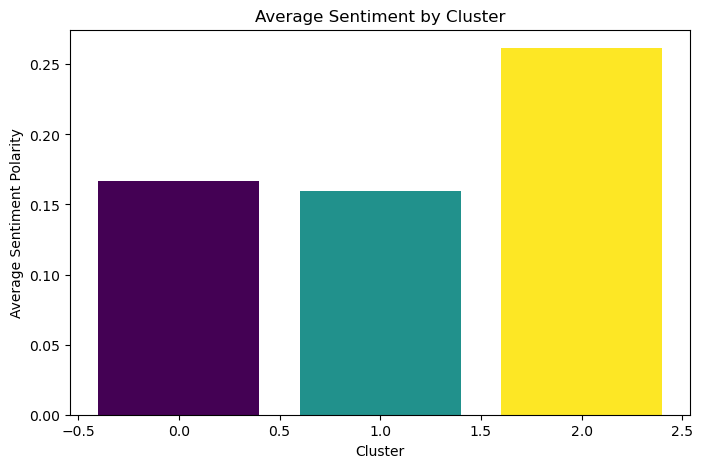

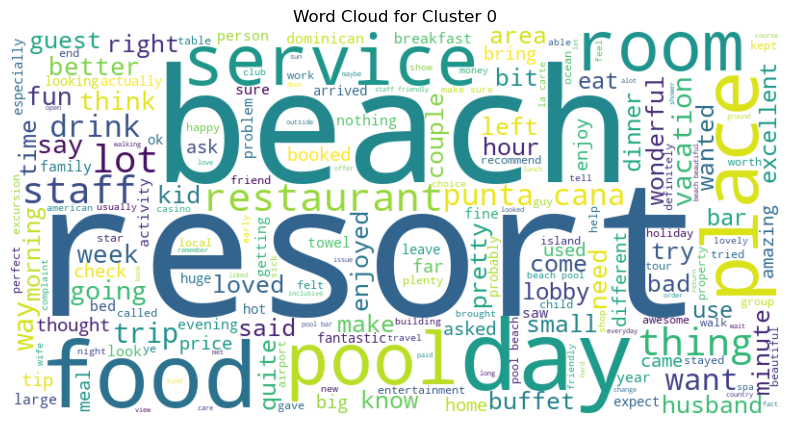

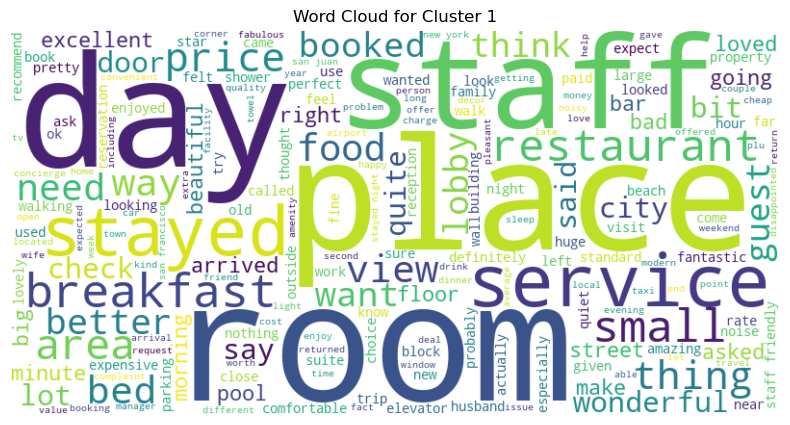

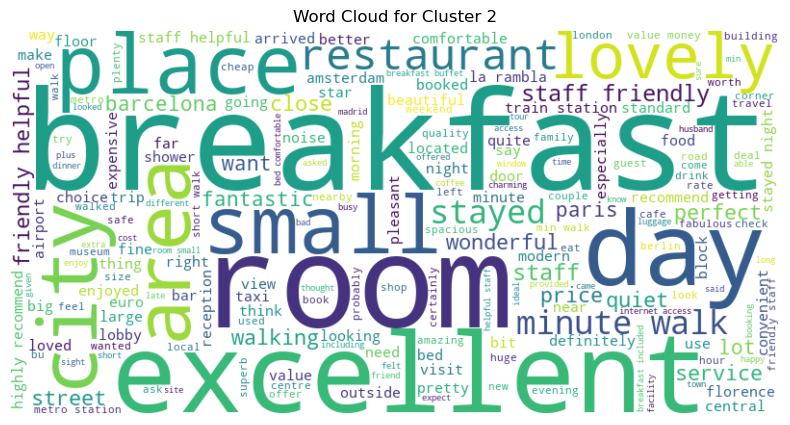

In [98]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
reviews["cluster"] = kmeans.fit_predict(X)

# Reduce dimensions with PCA
reduced_features = PCA(n_components=2).fit_transform(X.toarray())

# Scatter plot with explicit labels
cmap = plt.get_cmap("viridis")  # Use the same colormap for consistency
for cluster in range(3):
    cluster_points = reduced_features[reviews["cluster"] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                label=f"Cluster {cluster}", color=cmap(cluster / 2))
plt.legend()
plt.title("Review Clusters")
plt.xlabel("Dominant Variance: Location and Amenities")
plt.ylabel("Secondary Variance: Service and Rooms")
plt.show()

# Extract top words for each cluster
print("Top words in each cluster:")
for cluster in range(3):
    cluster_reviews = reviews[reviews["cluster"] == cluster]["processed_text"]
    all_words = " ".join(cluster_reviews).split()
    most_common = Counter(all_words).most_common(10)
    print(f"Top words in Cluster {cluster}: {most_common}")
    
# Calculate average polarity per cluster
cluster_sentiment = reviews.groupby("cluster")["polarity"].mean()
print("Average Sentiment Polarity by Cluster:")
print(cluster_sentiment)

# Bar plot for average sentiment by cluster with matching colors
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(cluster_sentiment.index, cluster_sentiment.values, 
              color=[cmap(i / 2) for i in range(3)])  # Match colors with scatter plot
ax.set_title("Average Sentiment by Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Average Sentiment Polarity")
plt.show()

# Generate word clouds for each cluster
for cluster in range(3):
    cluster_reviews = reviews[reviews["cluster"] == cluster]["processed_text"]
    text = " ".join(cluster_reviews)  # Combine all reviews in the cluster
    
    # Generate word cloud
    wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster}")
    plt.show()


# 10.Generate Insights

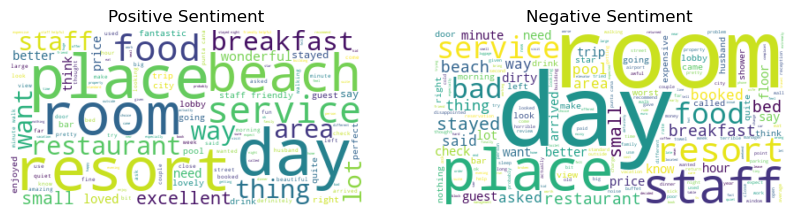

                                                  Review  polarity
13132  great little hotel great little hotel, rooms l...  0.208333
4666   great location hotel great location, rooms sma...  0.214286
8590   clean room staff friendly helpful, communal ar...  0.170833
9794   great location stayed hotel nights clean tidy ...  0.658333
19712  great hotel great location nice staff nice hot...  0.733333


In [75]:
# Generate positive and negative reviews text
positive_reviews = " ".join(reviews[reviews["polarity"] > 0]["processed_text"])
negative_reviews = " ".join(reviews[reviews["polarity"] < 0]["processed_text"])

# Generate word clouds
positive_wc = WordCloud(background_color="white").generate(positive_reviews)
negative_wc = WordCloud(background_color="white").generate(negative_reviews)

# Display word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Sentiment")

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Sentiment")

plt.show()

# Semantic Search (if embeddings are still intact)
query_result = semantic_search("clean rooms with friendly staff")
print(query_result[["Review", "polarity"]])



# 11.Semantic Search 

In [60]:
from sentence_transformers import SentenceTransformer, util


# Load the SentenceTransformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for all processed reviews
embeddings = model.encode(reviews["processed_text"].tolist(), show_progress_bar=True)

# Verify that embeddings have been generated
print(f"Generated {len(embeddings)} embeddings.")

def semantic_search(query, k=5):
    """
    Perform semantic search to find the top-k most similar reviews to the query.
    
    Args:
        query (str): The search query.
        k (int): Number of top results to return.
    
    Returns:
        DataFrame: Top-k similar reviews with their scores.
    """
    # Encode the query
    query_embedding = model.encode([query])

    # Compute cosine similarity between the query and all embeddings
    scores = util.cos_sim(query_embedding, embeddings)[0]

    # Get the indices of the top-k highest scores
    top_indices = scores.argsort(descending=True)[:k]

    # Return the top-k reviews with scores
    results = reviews.iloc[top_indices].copy()
    results["score"] = scores[top_indices].tolist()
    return results

# Example query
query = "clean rooms with friendly staff"
query_results = semantic_search(query, k=5)

# Display the results
print(query_results[["Review", "polarity", "score"]])


Batches:   0%|          | 0/641 [00:00<?, ?it/s]

Generated 20491 embeddings.
                                                  Review  polarity     score
13132  great little hotel great little hotel, rooms l...  0.208333  0.713907
4666   great location hotel great location, rooms sma...  0.214286  0.685067
8590   clean room staff friendly helpful, communal ar...  0.170833  0.658443
9794   great location stayed hotel nights clean tidy ...  0.658333  0.652792
19712  great hotel great location nice staff nice hot...  0.733333  0.648793


# 12.Save Results

In [61]:
reviews.to_csv(os.path.join(data_folder, "processed_reviews.csv"), index=False)
